## Define methods for later use

In [23]:
def make_splits(start, interval, time_before, time_after, measurements_count):
    splits = []
    if(measurements_count>0):
        splits.append((start - timedelta(seconds=time_before), start + timedelta(seconds=time_after)))
        splits.extend(make_splits(start + timedelta(seconds=interval),interval, time_before, time_after, measurements_count-1))
    return splits

def assign_range(times, splits):
    c_ix = 0
    in_split = False
    ranges = []
    for index, time in times.iteritems():
        if(splits[c_ix][0] <= time <= splits[c_ix][1]):
            in_split = True
        elif(in_split == True):
            if(c_ix +1 < len(splits)):
                c_ix += 1
            in_split = False

        if(in_split):
            ranges.append(str(splits[c_ix]))
        else:
            ranges.append(None)
    ranges = np.array(ranges)
    return ranges

### Import packages 

In [18]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

## Define variables

In [64]:
recordings_file = './data/Algus_17.19.40.txt'
target_file = ''

start_datetime = datetime(year=2020, month=1, day=15, hour=17, minute=19, second=40)
interval = 10
time_before = 1
time_after = 3
measurements_count = 30

## Import data

In [65]:
data = pd.read_csv(recordings_file, skiprows=6, delimiter=",", names=np.arange(13))
data = data.reset_index()
data['datetime'] = data[12].apply(lambda x: datetime.fromtimestamp(x/1000.0))
data = data[[2,3,5,'datetime']]
data.columns = ["unrailed","brow", "cheek", "datetime"]
data.head()

,unrailed,brow,cheek,datetime
0,0.0,0.00,0.00,2020-01-15 17:16:44.001
1,187500.0,-15598.25,22661.74,2020-01-15 17:16:44.017
2,187500.0,-15599.93,22668.74,2020-01-15 17:16:44.022
3,187500.0,-15599.73,22677.54,2020-01-15 17:16:44.024
4,187500.0,-15602.17,22672.80,2020-01-15 17:16:44.029


### Define splits of measurements

In [50]:
### Assign timestamps into ranges
splits = make_splits(start_datetime, interval, time_before, time_after, measurements_count)
splits[:5]
data['ranges'] = assign_range(data['datetime'], splits)

## Data visualization

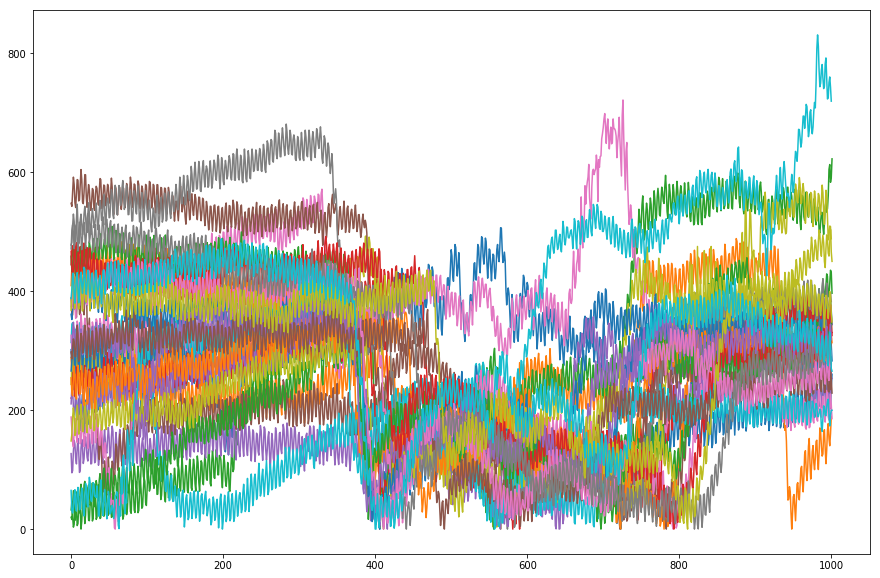

In [61]:
fig,ax = plt.subplots(figsize=(15,10))

groups = data.groupby('ranges')
for group in groups.groups:
    df = groups.get_group(group)
    line = df['cheek'].values
    line -= line.min()
    ax.plot(line)
    
plt.show()